# Post Earnings Event Study

In this notebook we explore the relationship between the post-earnings EPS surprise and the cumulative residual returns in the days following an earnings event. 

Conclusions:

* Estimze EPS deltas produce more alpha in the 1-to-3 days following an event than the Wall Street EPS deltas
* Negative earnings surprises tend to produce a larger negative return that positive surprises
* Market Cap analysis showed that Mid-Cap stocks produced the strongest alpha

## Data and Methodology

Datasources:

* EPS Consensus values (Estimize consensuses.csv)
* Asset historical prices (Zipline.io/Quandl prices dataset)
* SPY historical prices (Yahoo Finance)

Our first step is to generate the EPS surprises for each release by converting the raw EPS estimates (Estimize, WS, etc) and the actual reported EPS into an earnings yield (EY). We do this by summing the prior 3 quarter EPS actuals, adding the current quarter estimate (or actual) and dividing by that particular stock's 90 moving average; this helps to remove seasonal earnings effects and can be seen as analagous to an inverse PE-ratio:

$$EarningsYield_{estimize} = \frac{EPSActual_{q-3} + EPSActual_{q-2} + EPSActual_{q-1} + EPSEstimize_{q0}}{MovingAvgerage_{90day}}$$

$$EarningsYield_{actual} = \frac{EPSActual_{q-3} + EPSActual_{q-2} + EPSActual_{q-1} + EPSActual_{q0}}{MovingAvgerage_{90day}}$$

Next we calculate the EPS delta (surprise):

$$EPSDelta = EarningsYield_{actual} - EarningsYield_{estimize}$$

After calculating the EPS deltas for all reported releases, we group them by decile, with 1 being the lowest and 10 being the highest. This set of data represents the events we will plug into the event study.

The next step is to get the residual returns for each stock following an event. We calculate the residual returns using the CAPM with S&P500 index as the market portfolio:

$$E(R_{i,t})=b_0 + b_1 \cdot E(R_{M,t})$$

$$ResidualReturn_{i,t}=R_{i,t} - E(R_{i,t})$$

Usually returns are calculated from closing prices, however, due to the nature of earnings events, we are calculating using the opening prices. If we didn't do this, we would be grouping the over-night returns and the intra-day returns into one event interval.

Finally, we take the cumulative residual returns over the days in the event study grouped by the EPS delta decile.


In [5]:
# Imports

from datetime import timedelta
from IPython.display import HTML, Markdown
import logging.config
import os
import sys

from injector import Injector
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mstats

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetInfoService, CalendarService, EstimizeConsensusService, EventStudyService,
    MarketCapService
)
from estimize.pandas import dfutils

configure_logging('ERROR')

injector = Injector([DefaultModule])
calendar_service = injector.get(CalendarService)


In [6]:
def filter(df, column, value):
    return df[dfutils.column_values(df, column) == value]

def fix_row_index(row):
    index = row[0]
    cols = row[1]
    date = index[0]
    asset = index[1]

    if cols['bmo']:
        date = date - timedelta(days=1)

    date = calendar_service.get_valid_trading_end_date(date)

    return date, asset


def get_eps_deltas(start_date, end_date, population='estimize'):
    estimize_consensus_service = injector.get(EstimizeConsensusService)
    
    if population == 'estimize':
        eps_column = 'estimize.eps.weighted.yield'
    elif population == 'wallstreet':
        eps_column = 'wallstreet.eps.yield'
    else:
        raise ValueError('Unkown population: {}'.format(population))
    
    df = estimize_consensus_service.get_final_earnings_yields(start_date, end_date)
    df = df[['bmo', 'actual.eps.yield', eps_column]]
    df['eps_delta'] = df['actual.eps.yield'] - df[eps_column]
    df = df[['bmo', 'eps_delta']]
    df.dropna(inplace=True)
    
    return df


def get_post_earnings_events(start_date, end_date, population='estimize'):
    df = get_eps_deltas(start_date, end_date, population)
    
    # Fix index based on BMO
    df.index = pd.MultiIndex.from_tuples(list(map(fix_row_index, df.iterrows())))
    df.index.names = ['as_of_date', 'asset']
    
    # Add deciles
    df['decile'] = pd.qcut(df['eps_delta'].values, 10, labels=False) + 1
    df.drop(['bmo', 'eps_delta'], axis=1, inplace=True)
    
    return df


def run_event_study(start_date, end_date, join_fn=None, population='estimize'):
    event_study_service = injector.get(EventStudyService)
    events = get_post_earnings_events(start_date, end_date, population)
    
    if join_fn is not None:
        events = join_fn(start_date, end_date, events)
    
    df = event_study_service.run_event_study(
        events=events,
        on='open',
        days_before=0,
        days_after=20
    )
    
    return (df, events)


def join_sectors(start_date, end_date, events):
    asset_info_service = injector.get(AssetInfoService)
    df = asset_info_service.get_asset_info()['sector']

    events.reset_index(inplace=True)
    events.set_index('asset', inplace=True)
    events = events.join(df, how='inner')

    events.reset_index(inplace=True)
    events.set_index(['as_of_date', 'asset'], inplace=True)

    return events


def join_market_caps(start_date, end_date, events):
    market_cap_service = injector.get(MarketCapService)
    assets = dfutils.unique_assets(events)
    df = market_cap_service.get_market_caps(start_date, end_date, assets)['market_cap_type']
    df.rename({'market_cap_type': 'market_cap'}, inplace=True)

    events = events.join(df, how='inner')

    return events


def plot_results(df):
    """
    Plots cumulative residual returns based on decile.
    
    Parameters
    ----------
    df : pd.DataFrame
    """
    df = df.reset_index()
    df.set_index('event_time', inplace=True)
    
    plt.figure(figsize=(16, 10))
    
    deciles = list(df['decile'].astype('int').unique())
    deciles.reverse()
    
    cm = plt.get_cmap('jet_r') 
    c_norm  = colors.Normalize(vmin=deciles[-1], vmax=deciles[0])
    scalar_map = cmx.ScalarMappable(norm=c_norm, cmap=cm)
    
    for decile in deciles:
        if decile == deciles[0] or decile == deciles[-1]:
            linewidth = 2.0
        else:
            linewidth = 1.0
            
        color = scalar_map.to_rgba(decile)
            
        ddf = df.loc[df['decile'] == decile, 'cumulative_residual_return']
        ddf -= ddf.iloc[0]
        ddf *= 100.0
        ddf.plot(xticks=range(0, 21), label=decile, linewidth=linewidth, color=color)
        
    plt.plot([0 for _ in range(0, 21)], 'r--')
    
    plt.ylabel("% Cumulative Residual Return")
    plt.xlabel("Event Time")
    plt.gca().grid(True)
    plt.legend(title='Decile', loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()


def display_table(df):
    df = df.reset_index()

    df = pd.pivot_table(df, values='cumulative_residual_return', index='decile', columns=['event_time'])
    df *= 100
    df = df.subtract(df[0], axis='index')
    df = df[[1, 2, 3, 4, 5, 10, 15, 20]]
    df = df.applymap("{0:.2f}%".format)
    display(df)

    
def display_results(es, title=None):
    df, events = es
    num_events = df.loc[df.index.get_level_values('event_time') == 0, 'count'].sum()
    
    if title is not None:
        display(Markdown('### {}'.format(title)))
        
    print('Num Events: {:,}'.format(num_events))
    
    plot_results(df)
    display_table(df)


## EPS Deltas

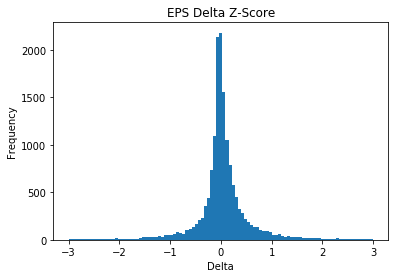

In [3]:
start_date = '2012-01-01'
end_date = '2017-10-01'

edf = get_eps_deltas(start_date, end_date)['eps_delta']
edf = mstats.winsorize(edf, limits=[0.01, 0.01])
edf = (edf - edf.mean()) / edf.std()
bins = np.linspace(-3, 3, 100)

plt.hist(edf, bins)
plt.title("EPS Delta Z-Score")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.show()


In [4]:
# Run all-time event study with wallstreet estimates

start_date = '2012-01-01'
end_date = '2017-10-01'

es_ws_alltime = run_event_study(start_date, end_date, population='wallstreet')

### All Stocks (All-time using WS EPS delta)

Num Events: 15,894


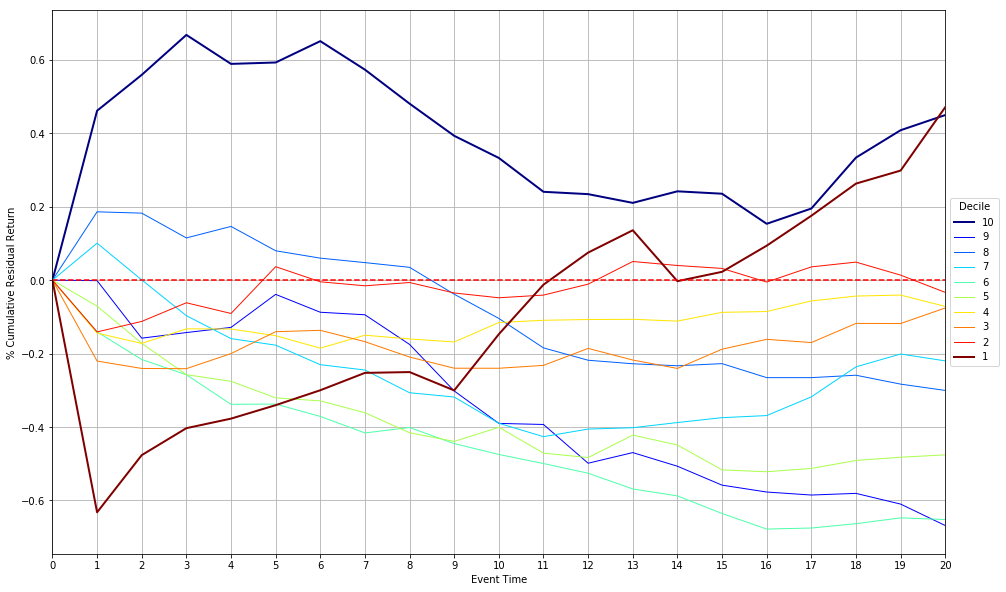

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.63%,-0.48%,-0.40%,-0.38%,-0.34%,-0.15%,0.02%,0.47%
2,-0.14%,-0.11%,-0.06%,-0.09%,0.04%,-0.05%,0.03%,-0.03%
3,-0.22%,-0.24%,-0.24%,-0.20%,-0.14%,-0.24%,-0.19%,-0.08%
4,-0.14%,-0.17%,-0.13%,-0.13%,-0.15%,-0.12%,-0.09%,-0.07%
5,-0.07%,-0.17%,-0.26%,-0.28%,-0.32%,-0.40%,-0.52%,-0.48%
6,-0.14%,-0.22%,-0.26%,-0.34%,-0.34%,-0.47%,-0.64%,-0.65%
7,0.10%,0.00%,-0.10%,-0.16%,-0.18%,-0.39%,-0.37%,-0.22%
8,0.19%,0.18%,0.11%,0.15%,0.08%,-0.10%,-0.23%,-0.30%
9,-0.00%,-0.16%,-0.14%,-0.13%,-0.04%,-0.39%,-0.56%,-0.67%


In [7]:
display_results(es_ws_alltime, 'All Stocks (All-time using WS EPS delta)')

In [6]:
# Run all-time event study

start_date = '2012-01-01'
end_date = '2017-10-01'

es_alltime = run_event_study(start_date, end_date)


### All Stocks (All-time using default Estimize EPS delta)

Num Events: 16,172


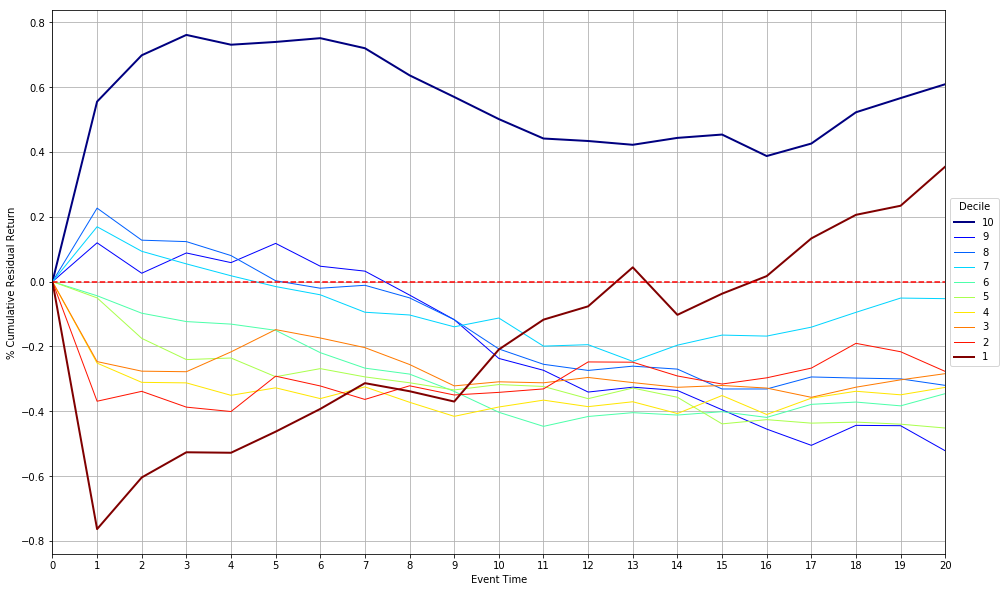

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.76%,-0.60%,-0.53%,-0.53%,-0.46%,-0.21%,-0.04%,0.35%
2,-0.37%,-0.34%,-0.39%,-0.40%,-0.29%,-0.34%,-0.32%,-0.28%
3,-0.25%,-0.28%,-0.28%,-0.22%,-0.15%,-0.31%,-0.32%,-0.28%
4,-0.25%,-0.31%,-0.31%,-0.35%,-0.33%,-0.39%,-0.35%,-0.33%
5,-0.05%,-0.17%,-0.24%,-0.24%,-0.29%,-0.32%,-0.44%,-0.45%
6,-0.04%,-0.10%,-0.12%,-0.13%,-0.15%,-0.40%,-0.40%,-0.35%
7,0.17%,0.09%,0.05%,0.02%,-0.02%,-0.11%,-0.16%,-0.05%
8,0.23%,0.13%,0.12%,0.08%,0.00%,-0.21%,-0.33%,-0.32%
9,0.12%,0.03%,0.09%,0.06%,0.12%,-0.24%,-0.40%,-0.52%


In [7]:
display_results(es_alltime, 'All Stocks (All-time using default Estimize EPS delta)')

In [2]:
# Run 2017 event study

start_date = '2017-01-01'
end_date = '2017-10-01'

es2017 = run_event_study(start_date, end_date)

NameError: name 'run_event_study' is not defined

### All Stocks (2017)

Num Events: 4,089


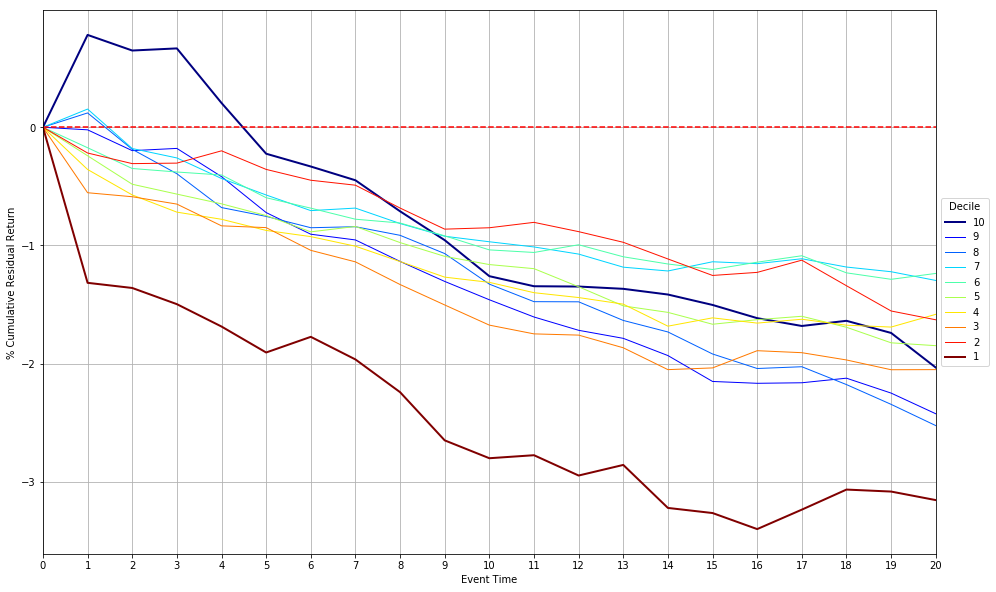

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-1.32%,-1.36%,-1.50%,-1.69%,-1.91%,-2.80%,-3.26%,-3.16%
2,-0.22%,-0.31%,-0.30%,-0.20%,-0.36%,-0.85%,-1.25%,-1.63%
3,-0.55%,-0.59%,-0.65%,-0.83%,-0.85%,-1.67%,-2.04%,-2.05%
4,-0.36%,-0.57%,-0.72%,-0.78%,-0.87%,-1.31%,-1.61%,-1.58%
5,-0.24%,-0.48%,-0.57%,-0.65%,-0.75%,-1.16%,-1.67%,-1.85%
6,-0.17%,-0.35%,-0.38%,-0.40%,-0.60%,-1.04%,-1.20%,-1.24%
7,0.15%,-0.18%,-0.26%,-0.43%,-0.57%,-0.97%,-1.14%,-1.30%
8,0.12%,-0.19%,-0.39%,-0.68%,-0.75%,-1.33%,-1.92%,-2.52%
9,-0.02%,-0.20%,-0.18%,-0.42%,-0.72%,-1.46%,-2.15%,-2.42%


In [9]:
display_results(es2017, 'All Stocks (2017)')

In [10]:
# Run 2016 event study

start_date = '2016-01-01'
end_date = '2017-01-01'

es2016 = run_event_study(start_date, end_date)

### All Stocks (2016)

Num Events: 5,128


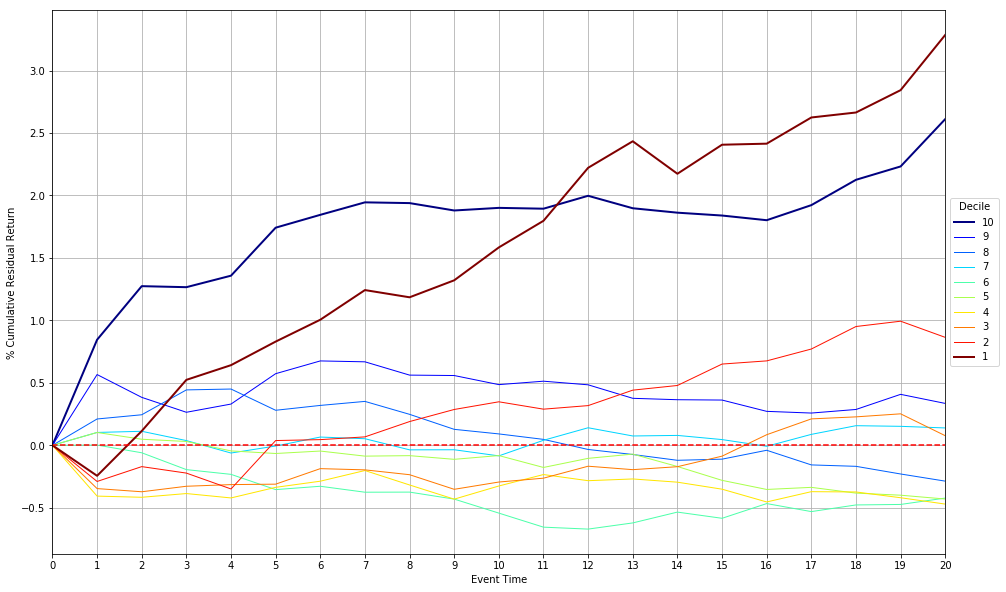

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.24%,0.11%,0.52%,0.64%,0.83%,1.58%,2.41%,3.28%
2,-0.29%,-0.17%,-0.22%,-0.35%,0.04%,0.35%,0.65%,0.86%
3,-0.35%,-0.37%,-0.33%,-0.31%,-0.31%,-0.29%,-0.09%,0.08%
4,-0.41%,-0.42%,-0.39%,-0.42%,-0.34%,-0.33%,-0.35%,-0.47%
5,0.10%,0.05%,0.03%,-0.05%,-0.07%,-0.08%,-0.28%,-0.43%
6,0.00%,-0.06%,-0.19%,-0.23%,-0.35%,-0.54%,-0.58%,-0.42%
7,0.10%,0.11%,0.04%,-0.06%,-0.01%,-0.08%,0.05%,0.14%
8,0.21%,0.24%,0.44%,0.45%,0.28%,0.09%,-0.11%,-0.29%
9,0.57%,0.38%,0.26%,0.33%,0.57%,0.49%,0.36%,0.34%


In [11]:
display_results(es2016, 'All Stocks (2016)')

In [12]:
# Run 2015 event study

start_date = '2015-01-01'
end_date = '2016-01-01'

es2015 = run_event_study(start_date, end_date)

### All Stocks (2015)

Num Events: 3,409


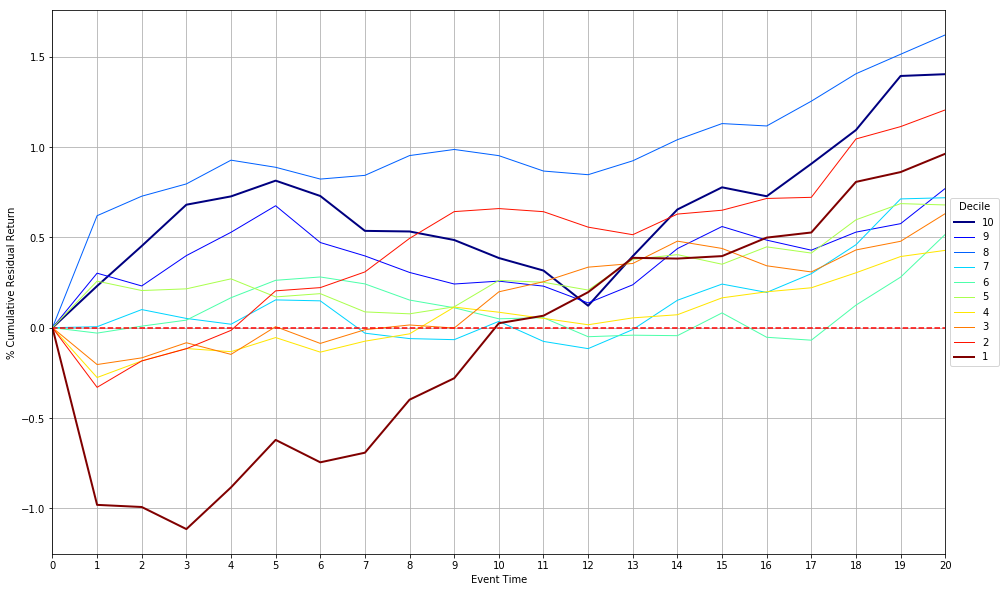

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.98%,-0.99%,-1.11%,-0.88%,-0.62%,0.02%,0.40%,0.96%
2,-0.33%,-0.18%,-0.12%,-0.01%,0.20%,0.66%,0.65%,1.21%
3,-0.20%,-0.17%,-0.08%,-0.15%,0.01%,0.20%,0.44%,0.63%
4,-0.28%,-0.18%,-0.12%,-0.13%,-0.05%,0.09%,0.17%,0.43%
5,0.26%,0.21%,0.22%,0.27%,0.17%,0.26%,0.35%,0.68%
6,-0.03%,0.01%,0.04%,0.17%,0.26%,0.05%,0.08%,0.52%
7,0.01%,0.10%,0.05%,0.02%,0.15%,0.04%,0.24%,0.72%
8,0.62%,0.73%,0.80%,0.93%,0.89%,0.95%,1.13%,1.62%
9,0.30%,0.23%,0.40%,0.53%,0.68%,0.26%,0.56%,0.77%


In [13]:
display_results(es2015, 'All Stocks (2015)')

In [14]:
# Run 2014 event study

start_date = '2014-01-01'
end_date = '2015-01-01'

es2014 = run_event_study(start_date, end_date)

### All Stocks (2014)

Num Events: 2,268


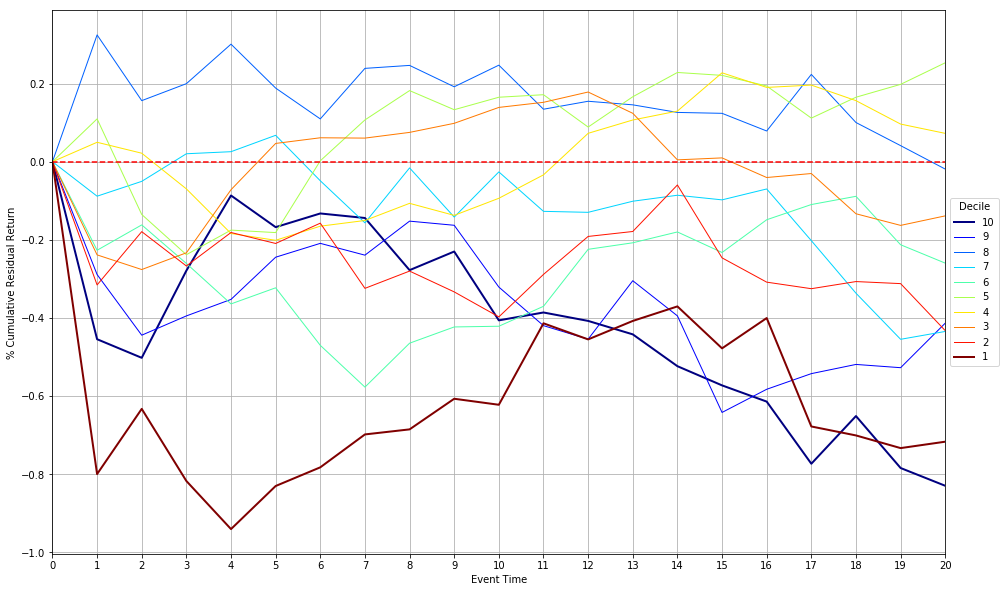

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.80%,-0.63%,-0.82%,-0.94%,-0.83%,-0.62%,-0.48%,-0.72%
2,-0.32%,-0.18%,-0.27%,-0.18%,-0.21%,-0.40%,-0.25%,-0.43%
3,-0.24%,-0.28%,-0.23%,-0.07%,0.05%,0.14%,0.01%,-0.14%
4,0.05%,0.02%,-0.07%,-0.18%,-0.20%,-0.09%,0.23%,0.07%
5,0.11%,-0.14%,-0.24%,-0.18%,-0.18%,0.17%,0.22%,0.25%
6,-0.23%,-0.16%,-0.26%,-0.36%,-0.32%,-0.42%,-0.23%,-0.26%
7,-0.09%,-0.05%,0.02%,0.03%,0.07%,-0.03%,-0.10%,-0.43%
8,0.32%,0.16%,0.20%,0.30%,0.19%,0.25%,0.12%,-0.02%
9,-0.29%,-0.44%,-0.40%,-0.35%,-0.24%,-0.32%,-0.64%,-0.41%


In [15]:
display_results(es2014, 'All Stocks (2014)')

In [16]:
# Run 2013 event study

start_date = '2013-01-01'
end_date = '2014-01-01'

es2013 = run_event_study(start_date, end_date)

### All Stocks (2013)

Num Events: 1,144


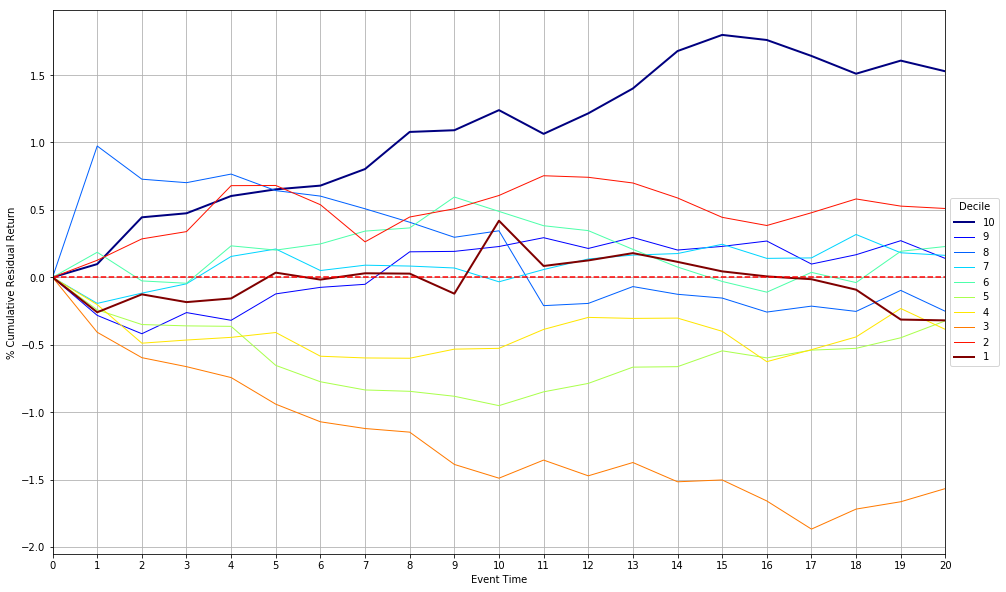

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.26%,-0.13%,-0.18%,-0.16%,0.03%,0.42%,0.04%,-0.32%
2,0.13%,0.28%,0.34%,0.68%,0.68%,0.61%,0.44%,0.51%
3,-0.41%,-0.60%,-0.66%,-0.74%,-0.94%,-1.49%,-1.50%,-1.57%
4,-0.20%,-0.49%,-0.47%,-0.45%,-0.41%,-0.53%,-0.40%,-0.39%
5,-0.24%,-0.35%,-0.36%,-0.36%,-0.65%,-0.95%,-0.55%,-0.32%
6,0.19%,-0.03%,-0.04%,0.23%,0.20%,0.49%,-0.03%,0.23%
7,-0.19%,-0.12%,-0.05%,0.15%,0.21%,-0.03%,0.25%,0.16%
8,0.97%,0.73%,0.70%,0.77%,0.64%,0.35%,-0.15%,-0.25%
9,-0.28%,-0.42%,-0.26%,-0.32%,-0.12%,0.23%,0.23%,0.14%


In [17]:
display_results(es2013, 'All Stocks (2013)')

In [18]:
# Run 2012 event study

start_date = '2012-01-01'
end_date = '2013-01-01'

es2012 = run_event_study(start_date, end_date)

### All Stocks (2012)

Num Events: 134


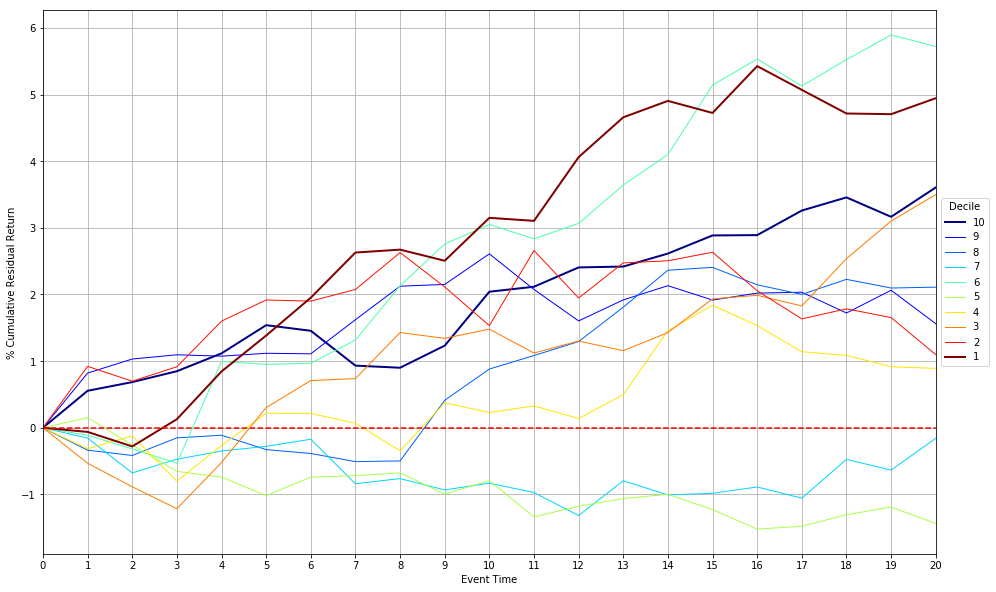

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.06%,-0.28%,0.13%,0.85%,1.38%,3.15%,4.72%,4.95%
2,0.92%,0.70%,0.91%,1.60%,1.92%,1.53%,2.63%,1.10%
3,-0.53%,-0.89%,-1.22%,-0.52%,0.30%,1.48%,1.93%,3.50%
4,-0.32%,-0.12%,-0.80%,-0.27%,0.22%,0.23%,1.84%,0.89%
5,0.15%,-0.26%,-0.65%,-0.74%,-1.02%,-0.79%,-1.23%,-1.44%
6,-0.11%,-0.32%,-0.53%,1.00%,0.95%,3.05%,5.14%,5.72%
7,-0.16%,-0.68%,-0.47%,-0.35%,-0.28%,-0.83%,-0.98%,-0.16%
8,-0.34%,-0.42%,-0.15%,-0.11%,-0.33%,0.88%,2.41%,2.11%
9,0.82%,1.03%,1.10%,1.07%,1.12%,2.61%,1.92%,1.56%


In [19]:
display_results(es2012, 'All Stocks (2012)')

## Sector Analysis

In [20]:
start_date = '2012-01-01'
end_date = '2017-10-01'

es_sectors = run_event_study(start_date, end_date, join_fn=join_sectors)

### Consumer Discretionary (All-Time)

Num Events: 3,491


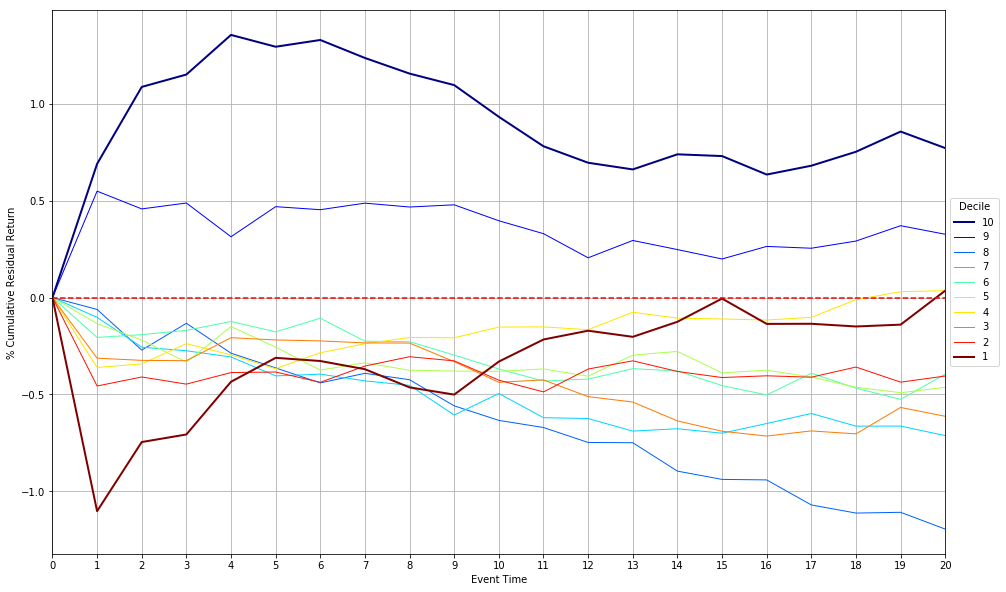

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-1.10%,-0.75%,-0.71%,-0.43%,-0.31%,-0.33%,-0.01%,0.04%
2,-0.46%,-0.41%,-0.45%,-0.39%,-0.38%,-0.43%,-0.41%,-0.41%
3,-0.31%,-0.32%,-0.33%,-0.21%,-0.22%,-0.44%,-0.69%,-0.61%
4,-0.36%,-0.34%,-0.24%,-0.30%,-0.37%,-0.15%,-0.11%,0.04%
5,-0.13%,-0.22%,-0.33%,-0.15%,-0.26%,-0.38%,-0.39%,-0.46%
6,-0.21%,-0.19%,-0.17%,-0.12%,-0.18%,-0.37%,-0.45%,-0.40%
7,-0.10%,-0.26%,-0.27%,-0.31%,-0.40%,-0.50%,-0.70%,-0.71%
8,-0.06%,-0.27%,-0.13%,-0.29%,-0.36%,-0.63%,-0.94%,-1.20%
9,0.55%,0.46%,0.49%,0.31%,0.47%,0.40%,0.20%,0.33%


### Consumer Staples (All-Time)

Num Events: 997


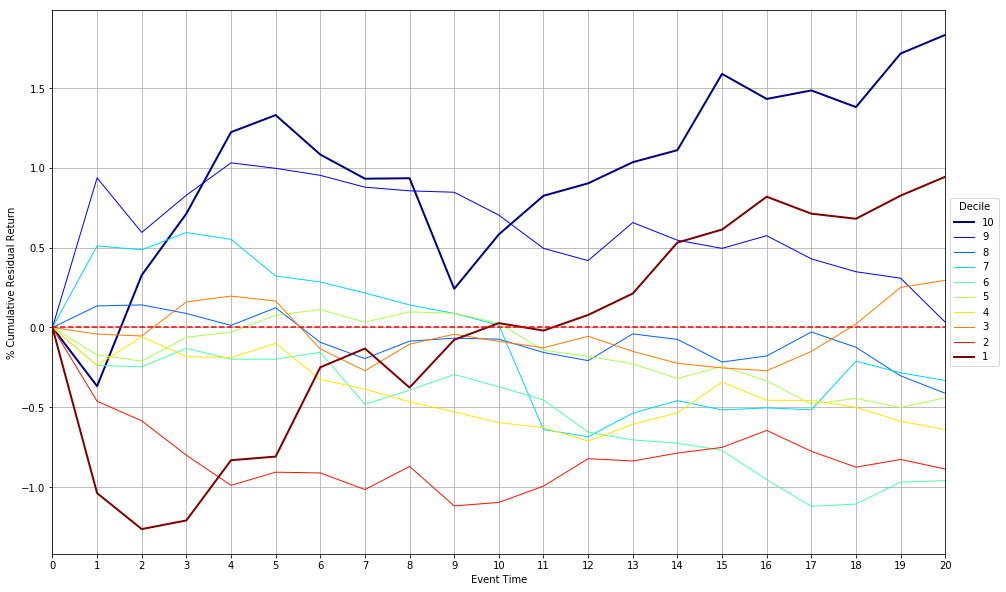

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-1.04%,-1.26%,-1.21%,-0.83%,-0.81%,0.03%,0.61%,0.94%
2,-0.46%,-0.58%,-0.80%,-0.99%,-0.91%,-1.10%,-0.75%,-0.89%
3,-0.04%,-0.05%,0.16%,0.20%,0.17%,-0.09%,-0.25%,0.30%
4,-0.24%,-0.06%,-0.18%,-0.19%,-0.10%,-0.60%,-0.34%,-0.64%
5,-0.17%,-0.21%,-0.06%,-0.03%,0.08%,0.03%,-0.24%,-0.44%
6,-0.24%,-0.25%,-0.13%,-0.20%,-0.20%,-0.37%,-0.77%,-0.96%
7,0.51%,0.49%,0.59%,0.55%,0.32%,0.01%,-0.52%,-0.33%
8,0.14%,0.14%,0.09%,0.01%,0.12%,-0.07%,-0.22%,-0.41%
9,0.94%,0.60%,0.83%,1.03%,1.00%,0.70%,0.50%,0.03%


### Energy (All-Time)

Num Events: 897


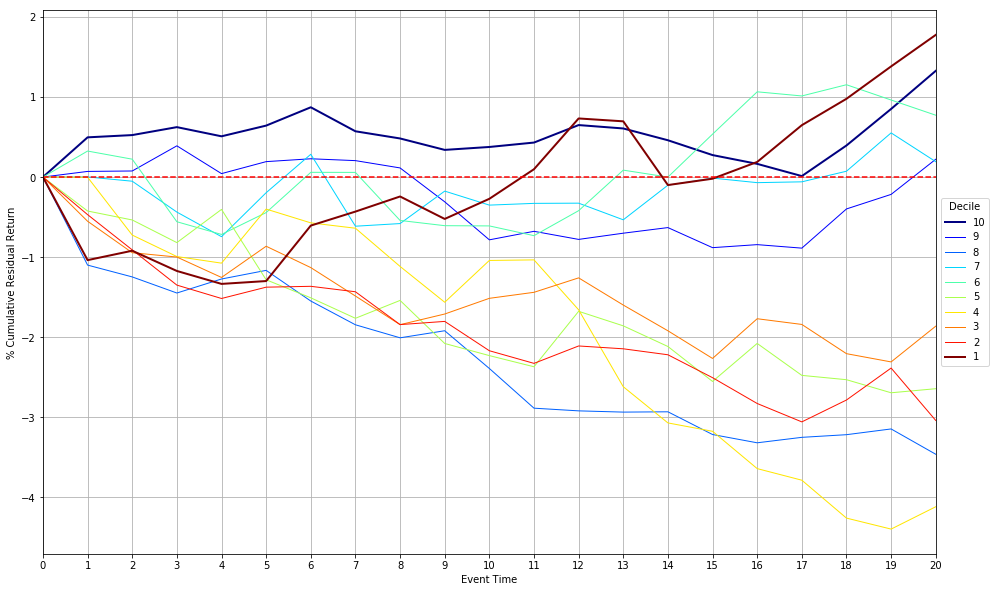

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-1.04%,-0.92%,-1.17%,-1.33%,-1.30%,-0.27%,-0.02%,1.78%
2,-0.47%,-0.91%,-1.35%,-1.52%,-1.37%,-2.17%,-2.51%,-3.04%
3,-0.55%,-0.94%,-1.00%,-1.25%,-0.86%,-1.51%,-2.26%,-1.86%
4,-0.00%,-0.72%,-0.99%,-1.07%,-0.40%,-1.04%,-3.17%,-4.12%
5,-0.42%,-0.54%,-0.82%,-0.40%,-1.28%,-2.23%,-2.55%,-2.64%
6,0.32%,0.22%,-0.56%,-0.72%,-0.44%,-0.61%,0.54%,0.77%
7,0.00%,-0.05%,-0.44%,-0.74%,-0.20%,-0.35%,-0.01%,0.19%
8,-1.10%,-1.25%,-1.45%,-1.27%,-1.17%,-2.39%,-3.21%,-3.46%
9,0.07%,0.08%,0.39%,0.04%,0.19%,-0.78%,-0.88%,0.22%


### Financials (All-Time)

Num Events: 824


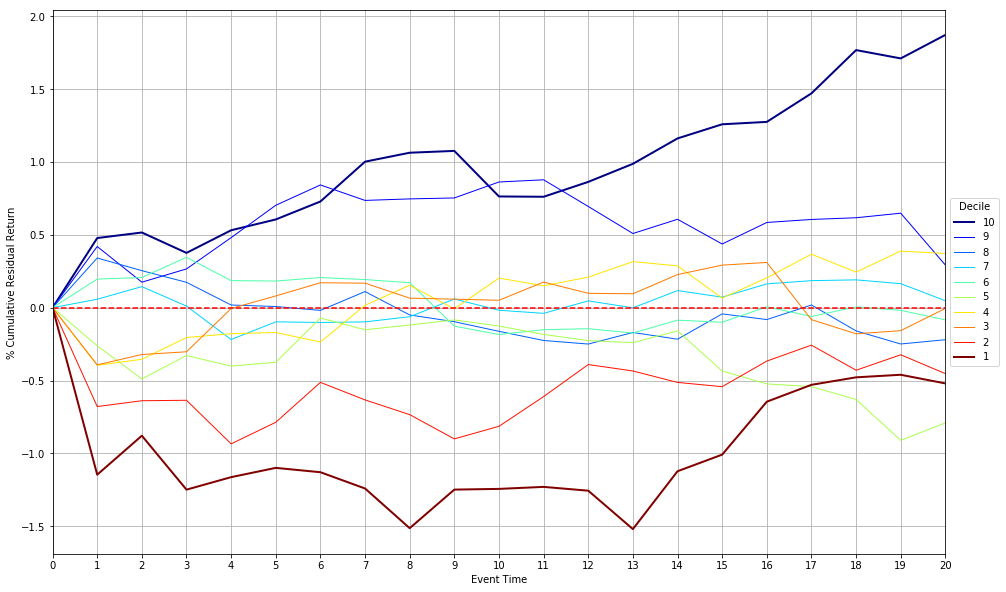

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-1.15%,-0.88%,-1.25%,-1.16%,-1.10%,-1.24%,-1.01%,-0.52%
2,-0.68%,-0.64%,-0.64%,-0.93%,-0.79%,-0.81%,-0.54%,-0.45%
3,-0.39%,-0.32%,-0.30%,-0.01%,0.08%,0.05%,0.29%,-0.01%
4,-0.40%,-0.35%,-0.20%,-0.18%,-0.17%,0.20%,0.07%,0.37%
5,-0.26%,-0.49%,-0.33%,-0.40%,-0.37%,-0.13%,-0.43%,-0.79%
6,0.20%,0.21%,0.35%,0.19%,0.18%,-0.18%,-0.10%,-0.08%
7,0.06%,0.14%,0.01%,-0.22%,-0.10%,-0.02%,0.07%,0.05%
8,0.34%,0.25%,0.17%,0.02%,0.01%,-0.16%,-0.04%,-0.22%
9,0.42%,0.18%,0.27%,0.48%,0.70%,0.86%,0.44%,0.29%


### Health Care (All-Time)

Num Events: 1,917


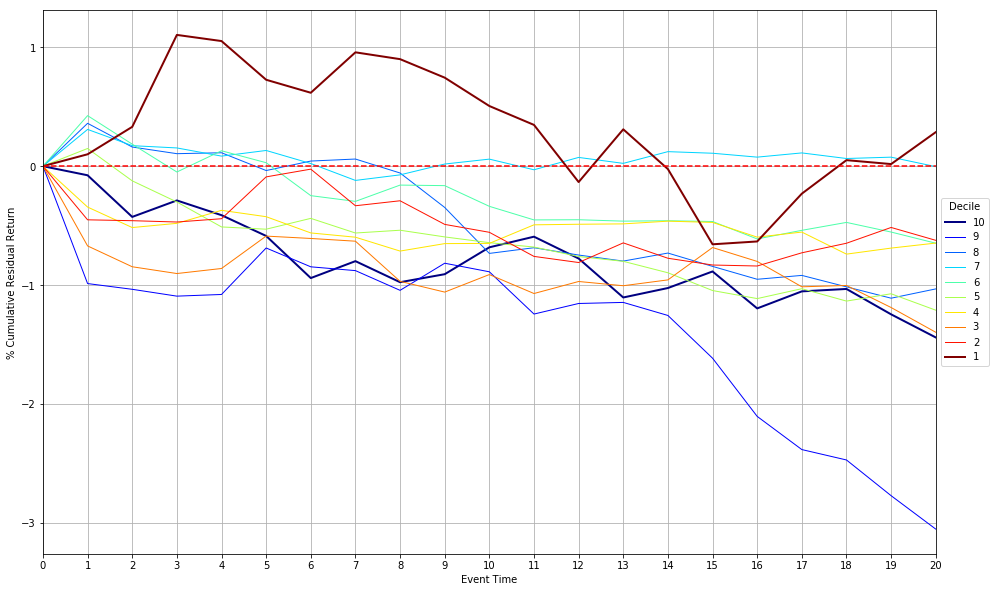

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,0.10%,0.33%,1.10%,1.05%,0.73%,0.51%,-0.66%,0.29%
2,-0.45%,-0.46%,-0.47%,-0.44%,-0.09%,-0.56%,-0.83%,-0.62%
3,-0.67%,-0.85%,-0.90%,-0.86%,-0.59%,-0.91%,-0.68%,-1.40%
4,-0.34%,-0.52%,-0.48%,-0.37%,-0.42%,-0.65%,-0.47%,-0.65%
5,0.15%,-0.12%,-0.30%,-0.51%,-0.53%,-0.64%,-1.05%,-1.21%
6,0.43%,0.19%,-0.05%,0.13%,0.03%,-0.34%,-0.47%,-0.65%
7,0.31%,0.17%,0.15%,0.08%,0.13%,0.06%,0.11%,-0.00%
8,0.36%,0.16%,0.11%,0.11%,-0.04%,-0.73%,-0.84%,-1.03%
9,-0.99%,-1.04%,-1.09%,-1.08%,-0.69%,-0.89%,-1.62%,-3.05%


### Industrials (All-Time)

Num Events: 2,615


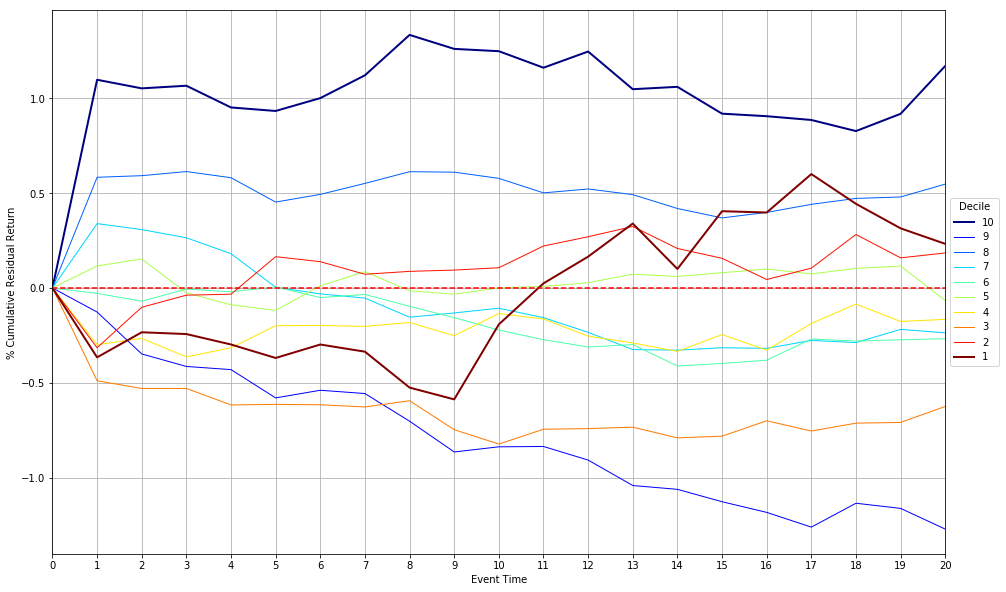

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.37%,-0.23%,-0.24%,-0.30%,-0.37%,-0.19%,0.41%,0.23%
2,-0.32%,-0.10%,-0.04%,-0.03%,0.17%,0.11%,0.16%,0.18%
3,-0.49%,-0.53%,-0.53%,-0.62%,-0.61%,-0.82%,-0.78%,-0.63%
4,-0.30%,-0.27%,-0.36%,-0.32%,-0.20%,-0.13%,-0.25%,-0.17%
5,0.12%,0.15%,-0.03%,-0.09%,-0.12%,0.00%,0.08%,-0.07%
6,-0.03%,-0.07%,-0.01%,-0.02%,0.01%,-0.22%,-0.40%,-0.27%
7,0.34%,0.31%,0.26%,0.18%,0.00%,-0.11%,-0.32%,-0.24%
8,0.58%,0.59%,0.61%,0.58%,0.45%,0.58%,0.37%,0.55%
9,-0.13%,-0.35%,-0.41%,-0.43%,-0.58%,-0.84%,-1.13%,-1.27%


### Information Technology (All-Time)

Num Events: 3,992


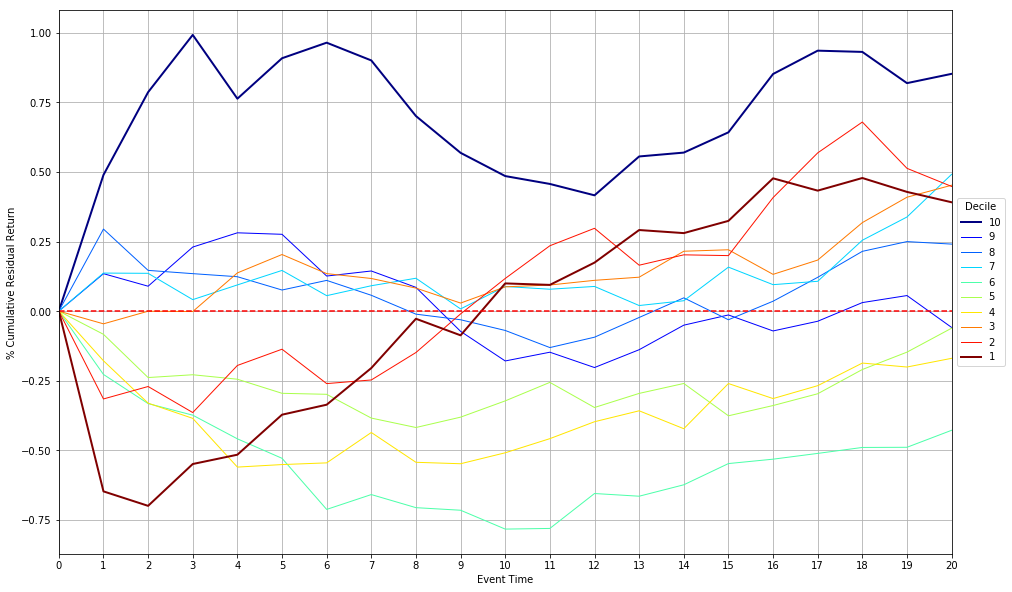

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.65%,-0.70%,-0.55%,-0.52%,-0.37%,0.10%,0.32%,0.39%
2,-0.32%,-0.27%,-0.36%,-0.20%,-0.14%,0.12%,0.20%,0.45%
3,-0.05%,-0.00%,-0.00%,0.14%,0.20%,0.09%,0.22%,0.45%
4,-0.18%,-0.33%,-0.39%,-0.56%,-0.55%,-0.51%,-0.26%,-0.17%
5,-0.08%,-0.24%,-0.23%,-0.24%,-0.30%,-0.32%,-0.38%,-0.06%
6,-0.23%,-0.33%,-0.37%,-0.46%,-0.53%,-0.78%,-0.55%,-0.43%
7,0.14%,0.14%,0.04%,0.09%,0.15%,0.09%,0.16%,0.49%
8,0.29%,0.15%,0.13%,0.12%,0.08%,-0.07%,-0.03%,0.24%
9,0.13%,0.09%,0.23%,0.28%,0.28%,-0.18%,-0.01%,-0.06%


### Materials (All-Time)

Num Events: 948


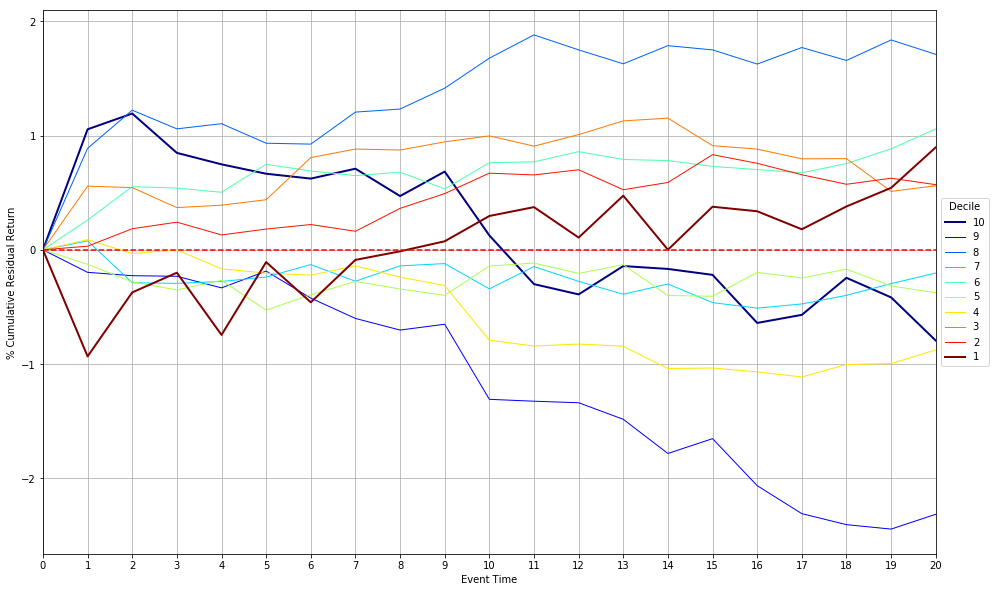

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.93%,-0.37%,-0.20%,-0.74%,-0.11%,0.30%,0.38%,0.90%
2,0.03%,0.18%,0.24%,0.13%,0.18%,0.67%,0.83%,0.57%
3,0.56%,0.54%,0.37%,0.39%,0.44%,1.00%,0.91%,0.56%
4,0.09%,-0.03%,-0.00%,-0.17%,-0.20%,-0.79%,-1.03%,-0.88%
5,-0.13%,-0.28%,-0.35%,-0.27%,-0.53%,-0.14%,-0.41%,-0.38%
6,0.26%,0.55%,0.54%,0.50%,0.75%,0.76%,0.73%,1.06%
7,0.08%,-0.29%,-0.29%,-0.28%,-0.24%,-0.34%,-0.46%,-0.20%
8,0.89%,1.22%,1.06%,1.10%,0.93%,1.68%,1.75%,1.71%
9,-0.20%,-0.23%,-0.23%,-0.33%,-0.19%,-1.31%,-1.65%,-2.32%


### Telecommunication Services (All-Time)

Num Events: 183


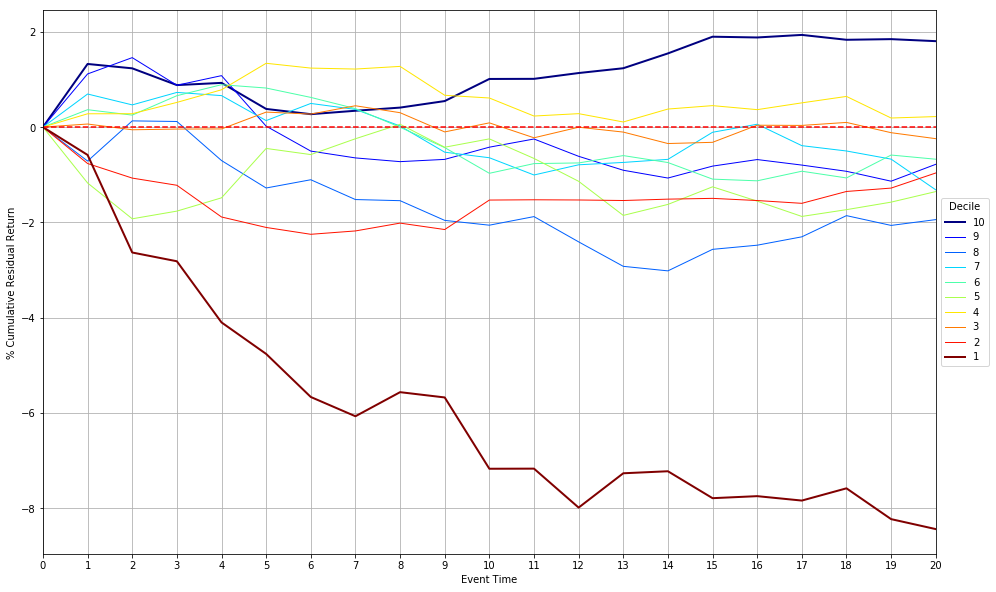

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.58%,-2.63%,-2.82%,-4.10%,-4.76%,-7.17%,-7.79%,-8.44%
2,-0.77%,-1.07%,-1.22%,-1.89%,-2.11%,-1.53%,-1.50%,-0.96%
3,0.06%,-0.06%,-0.04%,-0.04%,0.31%,0.09%,-0.32%,-0.24%
4,0.28%,0.28%,0.52%,0.78%,1.34%,0.61%,0.45%,0.22%
5,-1.17%,-1.93%,-1.76%,-1.49%,-0.45%,-0.25%,-1.25%,-1.35%
6,0.36%,0.25%,0.66%,0.89%,0.82%,-0.97%,-1.09%,-0.67%
7,0.69%,0.47%,0.73%,0.66%,0.14%,-0.64%,-0.11%,-1.32%
8,-0.71%,0.13%,0.12%,-0.70%,-1.28%,-2.06%,-2.57%,-1.94%
9,1.12%,1.46%,0.88%,1.08%,0.02%,-0.42%,-0.82%,-0.78%


### Utilities (All-Time)

Num Events: 308


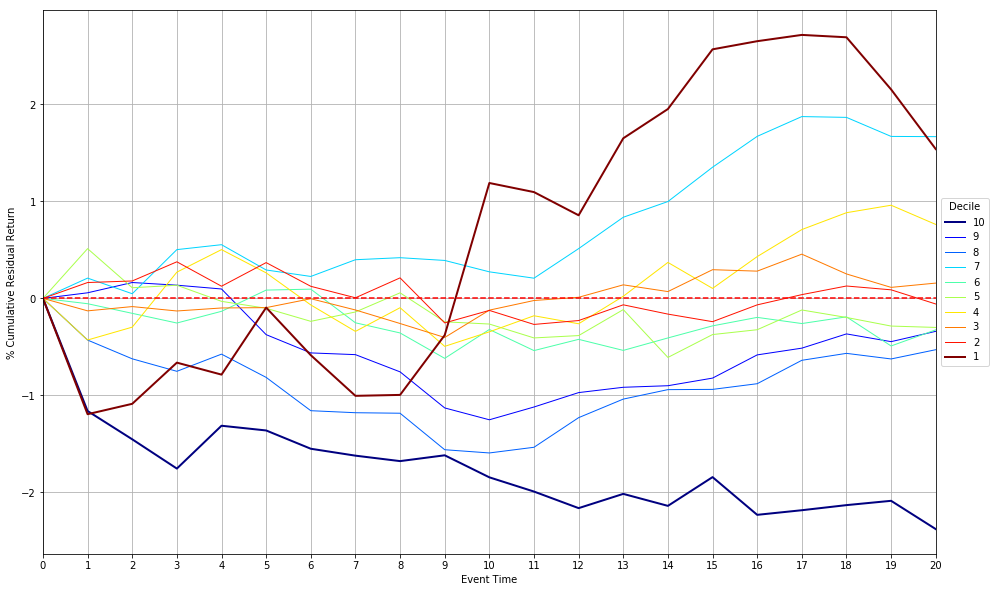

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-1.19%,-1.09%,-0.66%,-0.79%,-0.09%,1.19%,2.57%,1.54%
2,0.16%,0.18%,0.38%,0.13%,0.37%,-0.12%,-0.24%,-0.06%
3,-0.13%,-0.08%,-0.13%,-0.10%,-0.10%,-0.12%,0.30%,0.16%
4,-0.43%,-0.30%,0.27%,0.50%,0.26%,-0.34%,0.10%,0.76%
5,0.51%,0.11%,0.14%,-0.03%,-0.10%,-0.26%,-0.37%,-0.30%
6,-0.05%,-0.15%,-0.25%,-0.13%,0.09%,-0.32%,-0.28%,-0.32%
7,0.21%,0.05%,0.50%,0.55%,0.29%,0.27%,1.35%,1.67%
8,-0.43%,-0.62%,-0.75%,-0.57%,-0.81%,-1.59%,-0.94%,-0.53%
9,0.06%,0.16%,0.14%,0.10%,-0.37%,-1.25%,-0.82%,-0.34%


In [21]:
sectors = dfutils.column_values(es_sectors[0], 'sector').unique().tolist()

for sector in sectors:
    sdf = es_sectors[0]
    sdf = filter(sdf, 'sector', sector)
    display_results((sdf, None), '{} (All-Time)'.format(sector))


## Market Cap Analysis

In [22]:
start_date = '2012-01-01'
end_date = '2017-10-01'

es_market_caps = run_event_study(start_date, end_date, join_fn=join_market_caps)

### Micro Cap (All-Time)

Num Events: 345


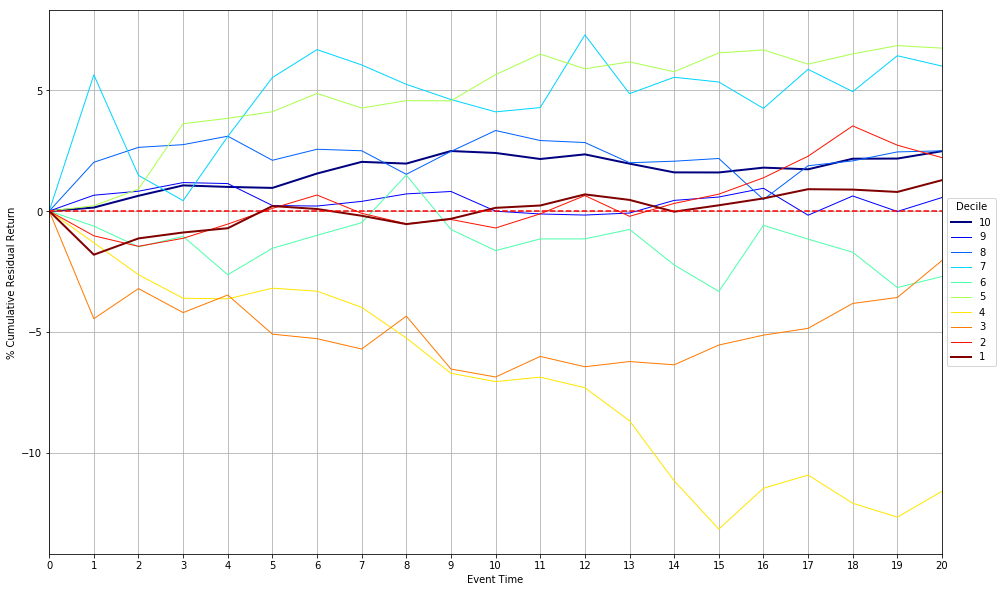

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-1.81%,-1.13%,-0.89%,-0.71%,0.21%,0.13%,0.24%,1.28%
2,-1.03%,-1.46%,-1.13%,-0.54%,0.11%,-0.70%,0.70%,2.21%
3,-4.46%,-3.21%,-4.20%,-3.48%,-5.10%,-6.87%,-5.55%,-2.05%
4,-1.31%,-2.64%,-3.61%,-3.64%,-3.19%,-7.06%,-13.17%,-11.60%
5,0.22%,0.91%,3.62%,3.84%,4.11%,5.65%,6.55%,6.74%
6,-0.62%,-1.48%,-1.05%,-2.64%,-1.54%,-1.64%,-3.33%,-2.71%
7,5.64%,1.48%,0.43%,3.09%,5.53%,4.11%,5.34%,6.00%
8,2.02%,2.64%,2.75%,3.10%,2.10%,3.33%,2.18%,2.49%
9,0.66%,0.82%,1.18%,1.14%,0.23%,-0.01%,0.58%,0.56%


### Small Cap (All-Time)

Num Events: 4,466


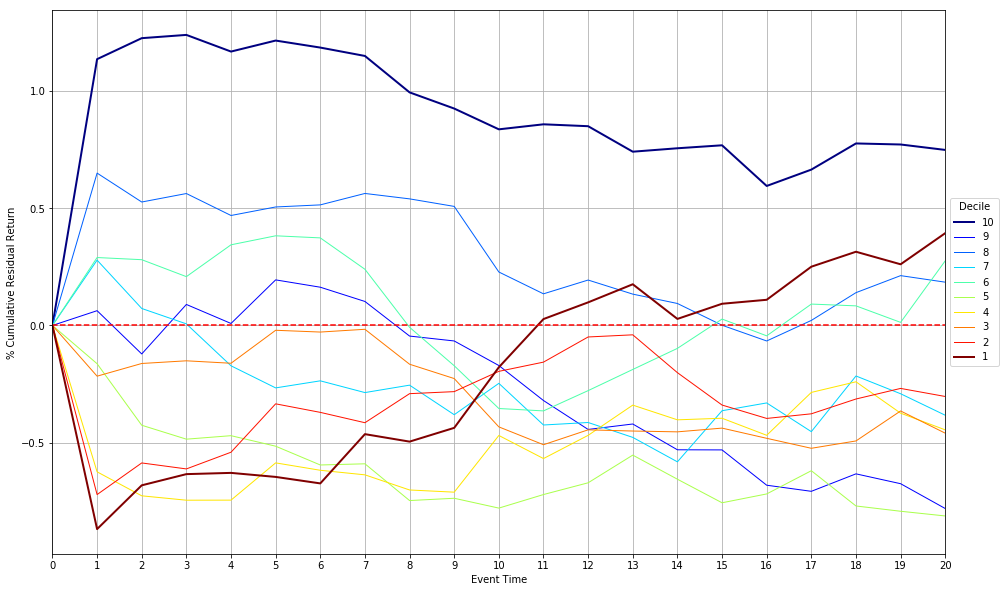

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.87%,-0.68%,-0.63%,-0.63%,-0.65%,-0.18%,0.09%,0.39%
2,-0.72%,-0.59%,-0.61%,-0.54%,-0.33%,-0.20%,-0.34%,-0.30%
3,-0.22%,-0.16%,-0.15%,-0.16%,-0.02%,-0.43%,-0.44%,-0.46%
4,-0.62%,-0.73%,-0.74%,-0.74%,-0.59%,-0.47%,-0.40%,-0.45%
5,-0.16%,-0.43%,-0.48%,-0.47%,-0.51%,-0.78%,-0.76%,-0.81%
6,0.29%,0.28%,0.21%,0.34%,0.38%,-0.35%,0.03%,0.28%
7,0.28%,0.07%,0.01%,-0.17%,-0.27%,-0.25%,-0.36%,-0.38%
8,0.65%,0.53%,0.56%,0.47%,0.51%,0.23%,0.00%,0.18%
9,0.06%,-0.12%,0.09%,0.01%,0.19%,-0.17%,-0.53%,-0.78%


### Mid Cap (All-Time)

Num Events: 6,056


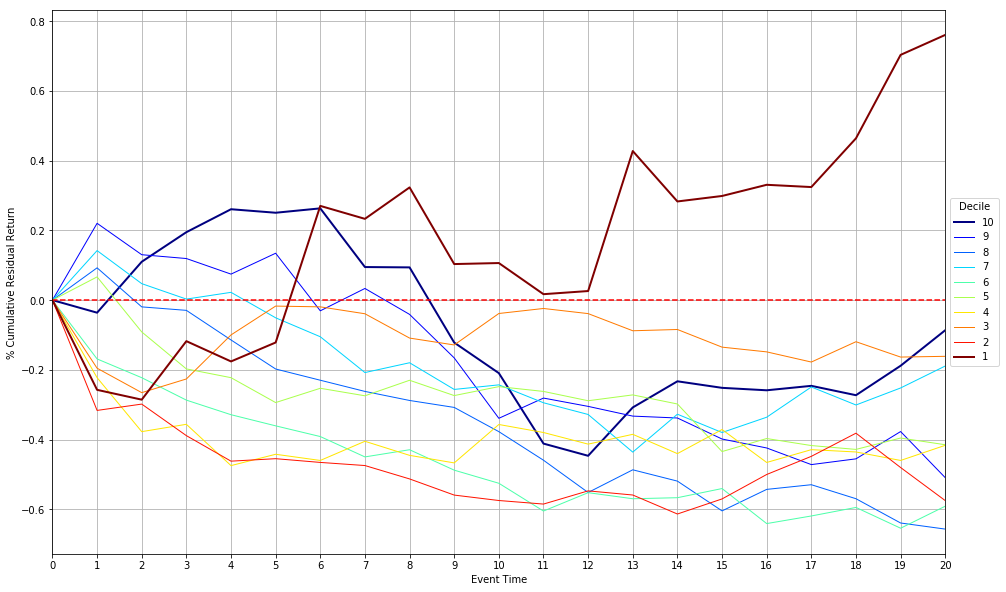

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.26%,-0.29%,-0.12%,-0.18%,-0.12%,0.11%,0.30%,0.76%
2,-0.32%,-0.30%,-0.39%,-0.46%,-0.45%,-0.57%,-0.57%,-0.57%
3,-0.20%,-0.27%,-0.23%,-0.10%,-0.02%,-0.04%,-0.13%,-0.16%
4,-0.22%,-0.38%,-0.36%,-0.47%,-0.44%,-0.36%,-0.37%,-0.42%
5,0.07%,-0.09%,-0.20%,-0.22%,-0.29%,-0.25%,-0.43%,-0.41%
6,-0.17%,-0.22%,-0.29%,-0.33%,-0.36%,-0.53%,-0.54%,-0.59%
7,0.14%,0.05%,0.00%,0.02%,-0.05%,-0.24%,-0.38%,-0.19%
8,0.09%,-0.02%,-0.03%,-0.11%,-0.20%,-0.38%,-0.60%,-0.66%
9,0.22%,0.13%,0.12%,0.07%,0.13%,-0.34%,-0.40%,-0.51%


### Large Cap (All-Time)

Num Events: 4,931


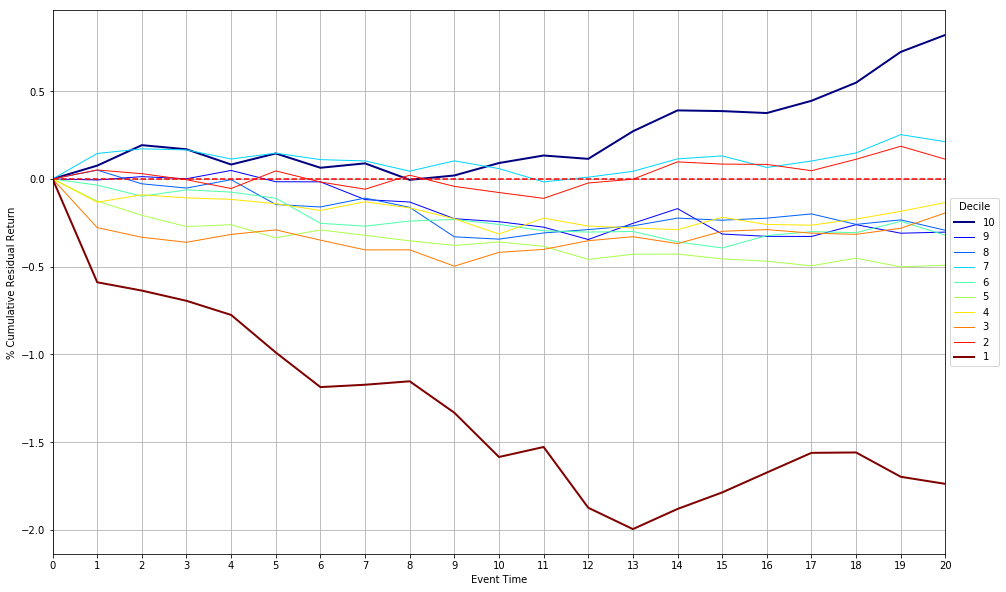

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-0.59%,-0.64%,-0.69%,-0.77%,-0.99%,-1.58%,-1.79%,-1.74%
2,0.05%,0.03%,-0.00%,-0.05%,0.05%,-0.08%,0.08%,0.11%
3,-0.28%,-0.33%,-0.36%,-0.32%,-0.29%,-0.42%,-0.30%,-0.19%
4,-0.13%,-0.09%,-0.11%,-0.12%,-0.14%,-0.31%,-0.22%,-0.13%
5,-0.13%,-0.21%,-0.27%,-0.26%,-0.34%,-0.36%,-0.46%,-0.49%
6,-0.04%,-0.10%,-0.06%,-0.08%,-0.11%,-0.26%,-0.39%,-0.32%
7,0.14%,0.17%,0.17%,0.11%,0.15%,0.06%,0.13%,0.21%
8,0.05%,-0.03%,-0.05%,-0.00%,-0.15%,-0.34%,-0.24%,-0.29%
9,-0.01%,0.01%,0.00%,0.05%,-0.02%,-0.24%,-0.31%,-0.30%


### Mega Cap (All-Time)

Num Events: 174


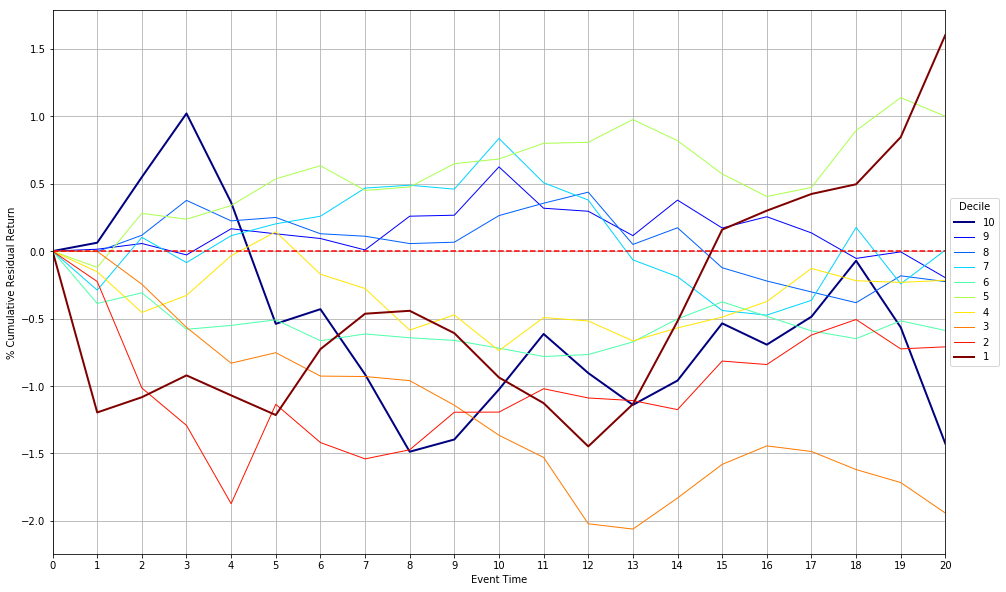

event_time,1,2,3,4,5,10,15,20
decile,,,,,,,,
1,-1.20%,-1.08%,-0.92%,-1.07%,-1.21%,-0.94%,0.16%,1.60%
2,-0.23%,-1.01%,-1.29%,-1.87%,-1.14%,-1.19%,-0.81%,-0.71%
3,-0.00%,-0.25%,-0.57%,-0.83%,-0.75%,-1.36%,-1.58%,-1.94%
4,-0.15%,-0.45%,-0.33%,-0.03%,0.14%,-0.74%,-0.49%,-0.22%
5,-0.12%,0.28%,0.24%,0.34%,0.54%,0.68%,0.57%,1.00%
6,-0.39%,-0.31%,-0.58%,-0.55%,-0.51%,-0.72%,-0.38%,-0.59%
7,-0.29%,0.10%,-0.08%,0.11%,0.20%,0.84%,-0.44%,0.01%
8,-0.00%,0.12%,0.38%,0.22%,0.25%,0.26%,-0.12%,-0.23%
9,0.01%,0.06%,-0.03%,0.17%,0.13%,0.62%,0.17%,-0.20%


In [23]:
market_cap_types = ['Micro', 'Small', 'Mid', 'Large', 'Mega']

for market_cap_type in market_cap_types:
    mdf = es_market_caps[0]
    mdf = filter(mdf, 'market_cap_type', market_cap_type)
    display_results((mdf, None), '{} Cap (All-Time)'.format(market_cap_type))
